<a href="https://colab.research.google.com/github/KarlX07/NLP-assignment/blob/main/Asising_5__NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install scikit-learn pandas matplotlib nltk spacy joblib
!python -m spacy download en_core_web_sm

import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Imports + Project Metadata**

In [23]:
import re
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm", disable=["ner"])
stop_words = set(stopwords.words("english"))

PROJECT = {
    "title": "Binary Text Classification using NLP Pipeline",
    "problem": "Classify news articles into two categories using full NLP pipeline.",
    "dataset": "20 Newsgroups (subset)",
    "techniques": ["cleaning", "tokenization", "lemmatization", "TF-IDF", "Logistic Regression", "Random Forest"]
}


# **Preprocessing Functions**

In [24]:
# Basic cleaning
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\\S+|www\\S+", " ", text)
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

# Lemmatization
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])


# **Load Dataset + Preprocess**

In [25]:
data = fetch_20newsgroups(
    subset="all",
    categories=["comp.sys.mac.hardware", "rec.sport.baseball"],
    remove=("headers", "footers", "quotes")
)

df = pd.DataFrame({"text": data.data, "label": data.target})

print("Cleaning...")
df["clean"] = df["text"].map(clean_text)

print("Lemmatizing... (slow but necessary for assignment)")
df["lemma"] = df["clean"].map(lemmatize)

X = df["lemma"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Dataset ready:", X_train.shape, X_test.shape)


Cleaning...
Lemmatizing... (slow but necessary for assignment)
Dataset ready: (1565,) (392,)


# **Build & Train Models**

In [26]:
models = {
    "logreg": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "rf": Pipeline([
        ("tfidf", TfidfVectorizer(max_features=20000)),
        ("clf", RandomForestClassifier(n_estimators=200))
    ])
}

trained_models = {}

for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model


Training: logreg
Training: rf


# **Evaluation + Confusion Matrix Plotting**


Model: logreg
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       193
           1       0.95      0.99      0.97       199

    accuracy                           0.97       392
   macro avg       0.97      0.97      0.97       392
weighted avg       0.97      0.97      0.97       392



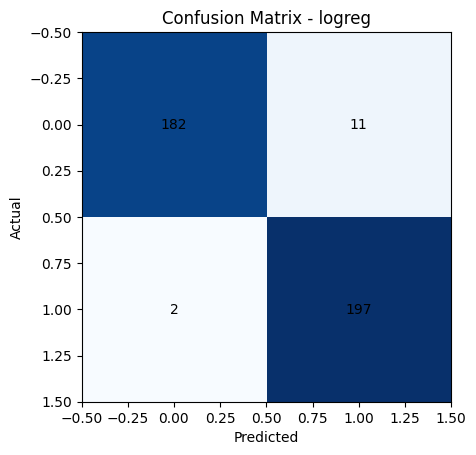


Model: rf
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       193
           1       0.93      0.98      0.96       199

    accuracy                           0.95       392
   macro avg       0.96      0.95      0.95       392
weighted avg       0.96      0.95      0.95       392



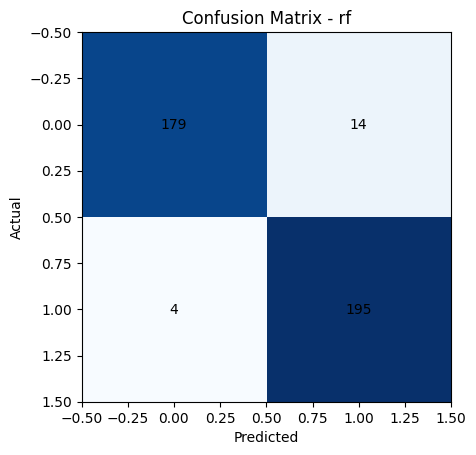

In [27]:
def plot_cm(cm, title):
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

results = {}

for name, model in trained_models.items():
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    p = precision_score(y_test, preds)
    r = recall_score(y_test, preds)
    f = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    results[name] = {"accuracy": acc, "precision": p, "recall": r, "f1": f}

    print("\nModel:", name)
    print(classification_report(y_test, preds))
    plot_cm(cm, f"Confusion Matrix - {name}")


# **Generate Short Summary Report**

In [28]:
with open("NLP_Project_Report.txt", "w") as f:
    f.write("NLP MINI PROJECT REPORT\n")
    f.write("========================\n\n")
    f.write("Title: " + PROJECT["title"] + "\n\n")
    f.write("Problem: " + PROJECT["problem"] + "\n\n")
    f.write("Models Evaluated:\n")

    for name, res in results.items():
        f.write(f"\n{name.upper()}:\n")
        for k,v in res.items():
            f.write(f"{k}: {v:.4f}\n")

    f.write("\nStrengths:\n- Clean pipeline\n- Good accuracy with TF-IDF\n\n")
    f.write("Limitations:\n- Only 2 categories used\n- No tuning\n\n")
    f.write("Future Work:\n- Add transformers\n- Expand dataset\n\n")

print("Report saved as NLP_Project_Report.txt")


Report saved as NLP_Project_Report.txt
